In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

from imblearn.pipeline import Pipeline
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
## Globals
COLORS = sns.palettes.color_palette('colorblind')
RANDOM_STATE = 42

# model params
MAX_DEPTH = 3
ITER = 2500
N_JOBS = -1

# cross validation params
N_SPLITS = 10
N_REPEATS = 3


# when google colab is used
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  DATA_PATH = 'drive/MyDrive/BigDataMaster/TFM/data/creditcard.csv'
# when docker is used
elif os.getenv('CONTAINER_BASE_DIR'):
  DATA_PATH = '../data/creditcard.csv'  
# when conda is used
else:
  DATA_PATH = '../../data/creditcard.csv'

In [3]:
SCORING = {
    'f1': make_scorer(f1_score, greater_is_better=True), 
    'recall': make_scorer(recall_score, greater_is_better=True), 
    'precision': make_scorer(precision_score, greater_is_better=True), 
    'roc_auc': make_scorer(roc_auc_score, greater_is_better=True), 
    'geometric_mean_score': make_scorer(geometric_mean_score, greater_is_better=True)}

In [4]:
df = pd.read_csv(DATA_PATH)
X, y = df.drop(columns=['Class']), df['Class']
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# resampling strategies
ros = RandomOverSampler(random_state=RANDOM_STATE)
rus = RandomUnderSampler(random_state=RANDOM_STATE)
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_STATE, k_neighbors=5, n_jobs=N_JOBS)

# estimators
lrc = LogisticRegression(random_state=RANDOM_STATE, max_iter=ITER, n_jobs=N_JOBS)
rfc = RandomForestClassifier(max_depth=MAX_DEPTH, random_state=RANDOM_STATE)

# cross validation strtategy
cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE)

In [6]:
## Logistic Regression
scores_lrc = cross_validate(lrc, X, y, scoring=SCORING, cv=cv, n_jobs=N_JOBS)

pipe = Pipeline([('resampling', ros), ('logistic', lrc)])
scores_ros_lrc = cross_validate(pipe, X, y, scoring=SCORING, cv=cv, n_jobs=N_JOBS)

pipe = Pipeline([('resampling', rus), ('logistic', lrc)])
scores_rus_lrc = cross_validate(pipe, X, y, scoring=SCORING, cv=cv, n_jobs=N_JOBS)

pipe = Pipeline([('resampling', smote), ('logistic', lrc)])
scores_smote_lrc = cross_validate(pipe, X, y, scoring=SCORING, cv=cv, n_jobs=N_JOBS)

In [7]:
## Random Forest Exp
scores_rfc = cross_validate(rfc, X, y, scoring=SCORING, cv=cv, n_jobs=N_JOBS)

pipe = Pipeline([('resampling', ros), ('forest', rfc)])
scores_ros_rfc = cross_validate(pipe, X, y, scoring=SCORING, cv=cv, n_jobs=N_JOBS)

pipe = Pipeline([('resampling', rus), ('forest', rfc)])
scores_rus_rfc = cross_validate(pipe, X, y, scoring=SCORING, cv=cv, n_jobs=N_JOBS)

pipe = Pipeline([('resampling', smote), ('forest', rfc)])
scores_smote_rfc = cross_validate(pipe, X, y, scoring=SCORING, cv=cv, n_jobs=N_JOBS)

In [8]:
rename_map = {
    'test_f1': 'F-Score', 
    'test_recall': 'Recall', 
    'test_precision': 'Precision', 
    'test_roc_auc': 'ROC AUC',
    'test_geometric_mean_score': 'G-Mean'}

df_scores_lrc = pd.DataFrame(scores_lrc).rename(columns=rename_map)
df_scores_ros_lrc = pd.DataFrame(scores_ros_lrc).rename(columns=rename_map)
df_scores_rus_lrc = pd.DataFrame(scores_rus_lrc).rename(columns=rename_map)
df_scores_smote_lrc = pd.DataFrame(scores_smote_lrc).rename(columns=rename_map)

df_scores_rfc = pd.DataFrame(scores_rfc).rename(columns=rename_map)
df_scores_ros_rfc = pd.DataFrame(scores_ros_rfc).rename(columns=rename_map)
df_scores_rus_rfc = pd.DataFrame(scores_rus_rfc).rename(columns=rename_map)
df_scores_smote_rfc = pd.DataFrame(scores_smote_rfc).rename(columns=rename_map)


df_scores_lrc['exp_id'] = 'LogReg'
df_scores_ros_lrc['exp_id'] = 'ROS + LogReg'
df_scores_rus_lrc['exp_id'] = 'RUS + LogReg'
df_scores_smote_lrc['exp_id'] = 'SMOTE + LogReg'

df_scores_rfc['exp_id'] = 'RanFor'
df_scores_ros_rfc['exp_id'] = 'ROS + RanFor'
df_scores_rus_rfc['exp_id'] = 'RUS + RanFor'
df_scores_smote_rfc['exp_id'] = 'SMOTE + RanFor'

df_scores = pd.concat(
    [df_scores_lrc, df_scores_ros_lrc, df_scores_rus_lrc, df_scores_smote_lrc,
     df_scores_rfc, df_scores_ros_rfc, df_scores_rus_rfc, df_scores_smote_rfc], 
    ignore_index=True)

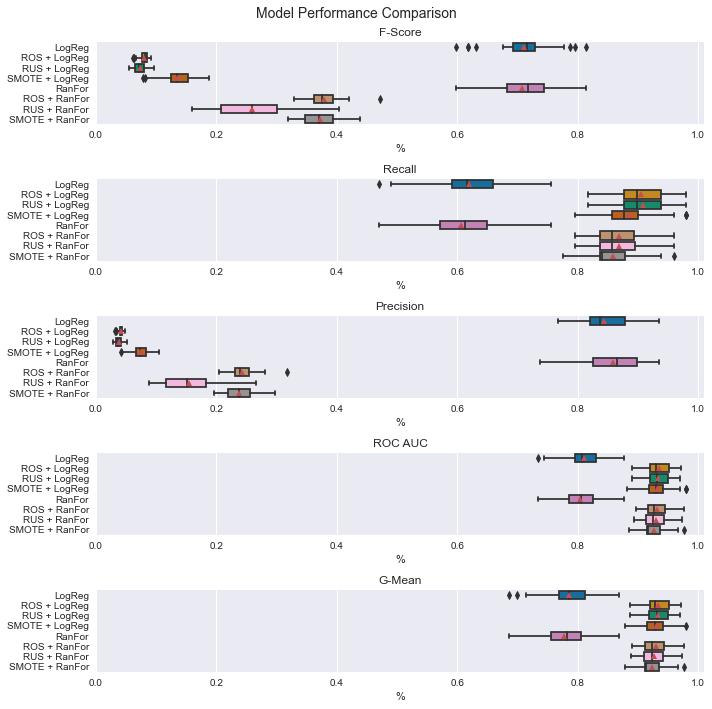

In [9]:
_ = plt.figure(figsize=[10,10])
plt.suptitle('Model Performance Comparison', fontsize=14)
FMT = '%.3f%%'

columns_to_plot = ['F-Score', 'Recall', 'Precision', 'ROC AUC', 'G-Mean']
for i, col in enumerate(columns_to_plot):
    plt.subplot(5, 1, i+1)
    ax = sns.boxplot(
        data=df_scores,
        x=col,
        y='exp_id',
        palette='colorblind',
        showmeans=True,
        orient='horizontal')
    ax.set_xlabel('%')
    plt.xlim([0,1.01])
    plt.ylabel(None)
    plt.title(col)

plt.tight_layout()

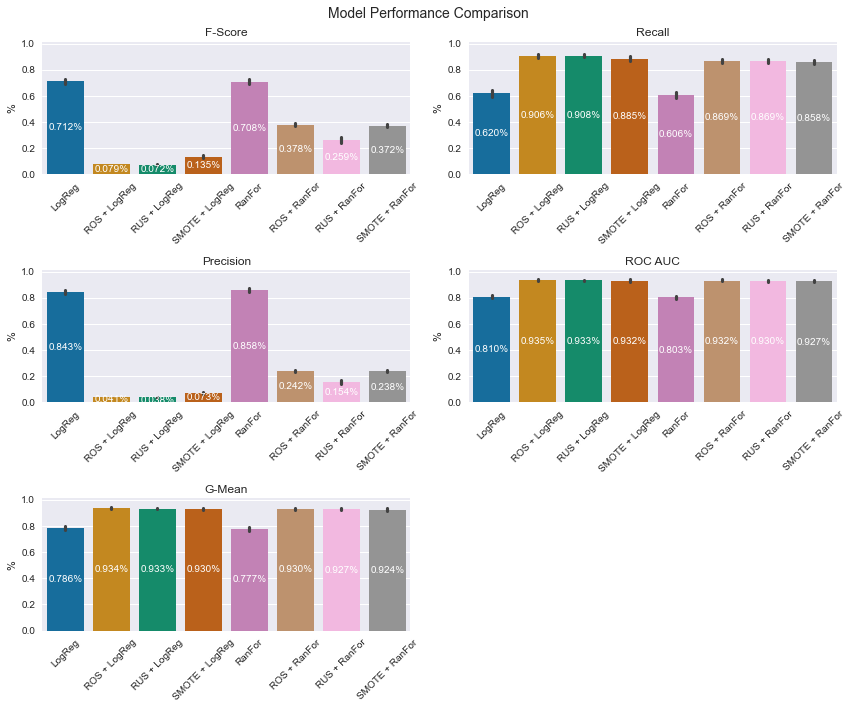

In [10]:
_ = plt.figure(figsize=[12,10])
plt.suptitle('Model Performance Comparison', fontsize=14)
FMT = '%.3f%%'

for i, col in enumerate(columns_to_plot):
    plt.subplot(3, 2, i+1)
    ax = sns.barplot(
        data=df_scores,
        x='exp_id',
        y=col,
        palette='colorblind')

    for container in ax.containers:
        ax.bar_label(container, label_type='center', color='white', fmt=FMT)

    ax.set_ylabel('%')
    plt.ylim([0,1.01])
    plt.xticks(rotation=45)
    plt.xlabel(None)
    plt.title(col)

plt.tight_layout()